# Self study 4

In this self study we investigate some community detection (graph clustering) techniques.  We make extensive use of the Networkx package. The documentation can be found here: https://networkx.org/documentation/stable/reference/index.html

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import sklearn as skl
import itertools

from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.quality import modularity

from sklearn.mixture import GaussianMixture

We are using a social network consisting of 71 lawyers. A description of the network and the original data can be found here:

https://www.stats.ox.ac.uk/~snijders/siena/Lazega_lawyers_data.htm

Of the three different relationships included in the data we will only be using the 'friendship' relation. This is a directed relationship, i.e., friends(a,b) does not necessarily imply friends(b,a) according to the data.

We load a version of the Lazega network data that only contains the 'friends' edges:

In [2]:
lazega=nx.readwrite.graphml.read_graphml('data.gml')

The nodes in the graph have the attributes "Practice" "Age" "Seniority" "Office" "Gender" "Status" . To obtain a dictionary with the values for a specified attribute for all nodes, we can use:

In [3]:
nx.get_node_attributes(lazega,'Office')

{'1': 1,
 '2': 1,
 '4': 1,
 '8': 1,
 '17': 1,
 '16': 1,
 '22': 1,
 '26': 1,
 '3': 2,
 '9': 1,
 '11': 1,
 '12': 1,
 '14': 2,
 '19': 1,
 '21': 1,
 '23': 1,
 '27': 1,
 '29': 1,
 '5': 2,
 '7': 2,
 '18': 2,
 '25': 2,
 '24': 1,
 '10': 1,
 '13': 1,
 '34': 1,
 '38': 1,
 '15': 3,
 '20': 1,
 '41': 1,
 '43': 1,
 '52': 1,
 '6': 2,
 '28': 2,
 '50': 2,
 '37': 3,
 '32': 2,
 '39': 1,
 '40': 1,
 '31': 2,
 '33': 2,
 '35': 2,
 '51': 2,
 '58': 2,
 '46': 2,
 '60': 1,
 '36': 1,
 '57': 1,
 '30': 2,
 '42': 1,
 '54': 1,
 '56': 1,
 '48': 1,
 '49': 1,
 '64': 1,
 '45': 1,
 '55': 1,
 '65': 1,
 '62': 1,
 '59': 2,
 '53': 1,
 '61': 1,
 '63': 2,
 '66': 1,
 '69': 1,
 '70': 1,
 '71': 1,
 '68': 1,
 '67': 1}

The following is a little helper function that returns an array of attribute values of nodes according to the order in which nodes are returned by the G.nodes() function

In [4]:
def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)

We can use this to plot the graph using one of the layout algorithms provided by networkx, and nodes colored according to one of the attributes:

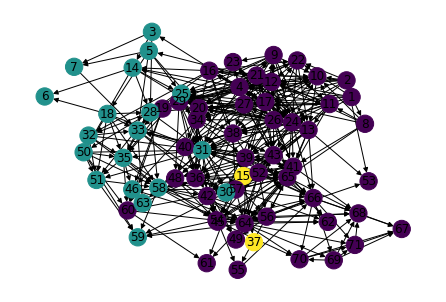

In [5]:
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Office'))

To make things a bit simpler, we turn the directed graph into an undirected one:

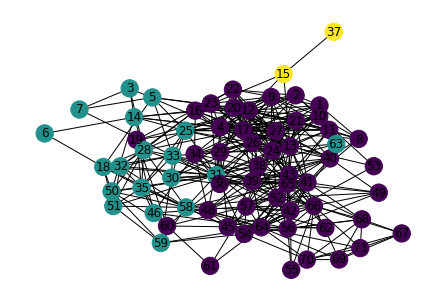

In [6]:
lazega=lazega.to_undirected()
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Office'))

The networkx.algorithms.community.quality.modularity function can be used to measure the similarity score of a graph clustering. The clusters (communities) have to be provided as a list of lists of nodes. The following code provides the necessary transformations:

In [7]:
attribute = 'Office'
def get_att_communities(G,attribute):
    att_array = get_att_array(G,attribute)
    att_dict= nx.get_node_attributes(G,attribute)
    att_communities = []
    for c in np.unique(att_array):
        comm_c =[]
        for n in lazega.nodes():
            if att_dict[n]==c:
                comm_c.append(n)
        att_communities.append(comm_c)
    return att_communities

att_communities = get_att_communities(lazega, attribute)
    
print("Modularity score of the communities defined by attribute ''{}'': {}".format(attribute,modularity(lazega,att_communities)))    

Modularity score of the communities defined by attribute ''Office'': 0.19672929190143276


**Task 1:** Use the networkx implementations of the Newman-Girvan algorithm to divide the Lazega network into 2,3,4,5 communities. Compare the communities returned by the algorithms with the communities defined by the attributes:
    
To what extend do the detected communities recover the attribute-defined communities? This is a case of what is called supervised cluster evaluation: a class label (or attribute) not used in the clustering process is assumed to represent a true underlying clustering, and we want our clustering method to recreate these underlying "ground truth" clusterings as much as possible (even though we cannot be sure that these "ground truth clusters" are indeed the most relevant clusters -- especially here, where we have multiple attributes that define competing "ground truths").
        
Compare the different community structures (attribute-based, and Newman-Girvan) according to their modularity scores.        
    
    

In [8]:
# Newman-Girman only considers the shortest path edge-betweenness to compute which edge to cut each time
# so it is structure based on the graph
# Computing the communities using the Girvan-Newman algorithm
# for community sizes k = 2,3,4,5 
dendrogram_iter = girvan_newman(lazega)
communities_k = []
k = 4 # 5 
for communities in itertools.islice(dendrogram_iter, 4):
    communities_k.append(communities)

In [9]:
# Computing modularity score for each community Girvan-Newman algorithm
mod_scores = []
for communities in communities_k:
    mod_scores.append(modularity(lazega,communities))
# print the results

print("Modularity scores for the communities defined by Girvan-Newman algorithm:")
for i,mod_score in enumerate(mod_scores):
    print("k = {}: {}".format(i+2,mod_score))

Modularity scores for the communities defined by Girvan-Newman algorithm:
k = 2: 0.004934014233578955
k = 3: 0.00489004466052349
k = 4: 0.07145997826646822
k = 5: 0.07341034289985618


In [10]:
# Compute the modularity score for the existing attributes
attributes = ["Practice", "Age", "Seniority", "Office", "Gender", "Status"]
for i, attr in enumerate(attributes):
    community = get_att_communities(lazega, attr)
    att_array = get_att_array(lazega, attr)
    k = len(np.unique(att_array))
    print("{:<15} | k = {}: {}".format(attr, k, modularity(lazega, community)))

Practice        | k = 2: 0.08067788518916338
Age             | k = 33: -0.005926470311116134
Seniority       | k = 27: 0.06420499871231965
Office          | k = 3: 0.19672929190143276
Gender          | k = 2: 0.07026023705881251
Status          | k = 2: 0.25532502936539336


### Comparison, 
we see that the highest modularity score is for Status, Office is also good
Modularity formula: $Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \gamma\frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)$

- where $m$ is the number of edges
- $A$ is the adjacency matrix of `G`
- $k_i$ is the degree of $i$ 
- $\gamma$ is the resolution parameter
- and $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community else 0.

#### Formula from slides
$Q(C_1, \ldots, C_k) = \sum_{i=1}^{k}(e_i - a_i^{2})$
    
    intution "The modularity score compares the actual proportion of intra-cluster edges with the expected number under the random graph model"

- $k$ is the number of communities
- $e_i$: proportion of edges that connect nodes
inside cluster i.
- $a_i$: fraction of edge endpoints that belong to
nodes in cluster i.
- $a_i^{2}$: the expected proportion of edges inside cluster $C_i$, 
    - Expectation of an edgepoint being in cluster $C_i$ is $a_i$ so for an edge to be fully in a $C_i$ both endpoints must be in $C_i$, 
    - so $a_i^{2}$ is the expected number of edges inside cluster $C_i$

#### Observations
- we see that status (0.25) and office (0.19) based on the existing attributes gives the best modularity scores, they are much higher than the (0.07) when using Newman-Girman, 
- Status suggests 2 communities, Office suggests 3 commmunites
- while Newman-Girman suggest 5 communities
- In general the modularity score when using edge-betweeness (newman-girman) is not good, one would expect it to be more in between 0.3-0.7 typically

We now move on to the model-based community detection method. A "cheap" way to obtain embeddings of the nodes into 2-dimensional space is to use a graph layout algorithm. Networkx provides a few layout algorithms that return a dictionary of nodes:coordinates :

In [11]:
embedding=nx.kamada_kawai_layout(lazega)

In [12]:
len(embedding)

69

**Task 2:** Calculate the log-likelihood of the lazega graph based on embeddings provided by different layout algorithms (cf. slide 31). Which layout provides the best "explanation" for the observed edges based on our probabilistic model?

Given coordinates for the nodes, we can now fit a Gaussian mixture model to these points. First we need to reshape our data again a little bit to fit the requirements of the next method in our pipeline: we turn the dictionary of positions into a standard array, where the first column contains the node identifier (not really needed in the following, but good to have it for possible checks along the road):

We use the sklearn.mixture.GaussianMixture class. Apart from specifying the number of mixture components, we can also restrict the covariance matrices in different ways. For example, covariance_type='tied' means that in the learned model all components have the same covariance matrix (which is the same restriction that we saw in the LDA classification model). 

In [15]:
gmm=GaussianMixture(n_components=2,covariance_type='tied').fit(pos_array[:,1:3])

Since we are doing clustering, we are using the 'predict' function of the learned mixture models on the training points:

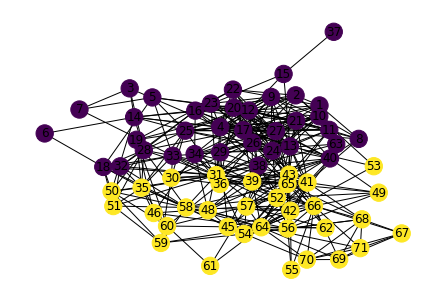

In [16]:
clusters=gmm.predict(pos_array[:,1:3])

nx.draw(lazega,pos=embedding,with_labels=True,node_color=clusters)

In [23]:
from scipy.stats import multivariate_normal

def log_likehood(gmm, k, pos_array):
    # k is the number of clusters / same as number of mixture components
    lambdas, mus, sigmas = gmm.weights_, gmm.means_, gmm.covariances_
    
    sum_over_i = 0
    for zi in pos_array[:,1:3]:

        sum_over_k = 0
        for j in range(k): 
            # because of tied covariance, sigmas[j] is the same for all j 
            sum_over_k += lambdas[j] * multivariate_normal.pdf(zi, mus[j], sigmas[j])  
        
        sum_over_i += np.log(sum_over_k)
    
    return sum_over_i

def pr_log_for_layout(pos_array, max_community_size = 6):
    for k in range(2, max_community_size):
        gmm=GaussianMixture(n_components=k,covariance_type='full',random_state=0).fit(pos_array[:,1:3])
        print("k = {}: {}".format(k, log_likehood(gmm, k, pos_array)))

pr_log_for_layout(pos_array)

k = 2: -54.41197835814218
k = 3: -51.93947148794584
k = 4: -49.45844887214759
k = 5: -47.46667269845928


#### Task 2 text desc.
- To estimate the mixture model we compute the log-liklyhood of the embedding given then estimated mixture model
    - $\sum_{i=1}^n\log \left(\sum_{j=1}^k \lambda_j \mathcal{N}(\mu_j,\Sigma_j)(\mathbf{z}_i)\right)$
    - $n$ is the number of nodes or points in the embedding
    - $k$ is the number of communities / also the number of mixture components
    - $\lambda_j$ is the weight of each mixuture in the Gaussian Mixture Model
    - $\mathcal{N}(\mu_j,\Sigma_j)(\mathbf{z}_i)$ is the probability that $\mathbf{z}_i$ belongs to community $j$

#### Observations
- We see again that the Gaussian mixture model prefers more communities like 5, similar to Newman-Girman, 
- and still contradictory to the attribute values, which preferred 2 for status and 3 for office   

**Task 3:** Compare the modularity scores obtained by Gaussian mixture models with n_components = 2,3,4,5 and embeddings obtained from different layout methods. How does the modularity score relate to the likelihood scores computed in Task 2 -- do embeddings with higher likelihood score lead to clusterings with higher modularity? 

In [ ]:
# We start by computing the log-likelihood of the mixture models estimated for a couple of embedding layout functions
layouts = {'kamada_kawai_layout': nx.kamada_kawai_layout, 'Circular': nx.circular_layout, 'Random': nx.random_layout,
           'Shell': nx.shell_layout, 'Spectral': nx.spectral_layout, 'Spring': nx.spring_layout}

# Compute log-likelihood for each layout
# for k in range(2, 6):
for name, layout in layouts.items():
    embedding = layout(lazega)
    pos_array = np.zeros((len(embedding),3))

    for i,k in enumerate(embedding.keys()):
        pos_array[i,0]=int(k)
        pos_array[i,1:3]=embedding[k]
    
    print(name)
    pr_log_for_layout(pos_array, max_community_size = 6)

In [ ]:
# Function to compute comminutes from an estimated Gaussian Mixture Model
# Have the gmm predict the cluster of the embedding, and then assigne them to their clusters
def communities_from_gmm(gmm, G, pos_array, k):
    """ Compute communities from a Gaussian mixture model.
    """ 
    preds = gmm.predict(pos_array[:,1:])   
    communities = [[] for _ in range(k)]
    for i, node in enumerate(G.nodes()):
        communities[preds[i]].append(node)
    return communities

In [ ]:
# Now we compute the modularity scores for each of the proposed embeddings above
for name, layout in layouts.items():
    embedding = layout(lazega)
    pos_array = np.zeros((len(embedding),3))

    for i,k in enumerate(embedding.keys()):
        pos_array[i,0]=int(k)
        pos_array[i,1:3]=embedding[k]
    
    print("Modularity score", name)
    for k in range(2, 6):
        gmm = GaussianMixture(n_components=k,covariance_type='tied',random_state=0).fit(pos_array[:,1:3])
        communities = communities_from_gmm(gmm, lazega, pos_array, k)
        print("k = {}: {}".format(k, modularity(lazega, communities)))

#### Task 3 text description.
**is it the case that higher log-likelihood leads to higher modularity?**
- it seems not be too influential from the above 
- specifically the kamada_kawai_layout has among the lower likelihood scores, but higher modularity scores

Using coordinates calculated by layout algorithms for our graph mixture model is of course not what one is supposed to do. The "proper" approach is to learn vectors z_i by maximizing the log-likelihood function. A full implementation of such an approach is outside the scope of what we can do in this self study. However, with relatively little effort we can take some steps in this direction. 

We make use of the fact that we already have a very special vector representation of the nodes in form of the rows of the adjacency matrix, which we can access as follows:


In [ ]:
am=nx.adjacency_matrix(lazega)
idx=2
print("The adjacency vector for node {} in a sparse vector representation is \n{}".format(list(lazega.nodes)[idx],am[idx,:]))
print("The same in a standard dense vector representation: \n{}".format(am[idx,:].todense()))

Using the dense vector representations, we can use the np.linalg.norm function to compute the Euclidean distance between two adjacency vectors:

In [ ]:
idx0=0
idx1=3
print("The distance between the adjacency vectors of nodes {} and {} is {}".format(list(lazega.nodes)[idx0],\
                                                                              list(lazega.nodes)[idx1],\
                                                                                  np.linalg.norm(am[idx0,:].todense()-am[idx1,:].todense())))

**Task 4:** Construct the 69x69 distance matrix between the nodes of the lazega graph based on the Euclidean distance between the adjacency vectors. Use this matrix and the multidimensional scaling implementation sklearn.manifold.MDS to construct 2-dimensional vector representations for the nodes. Fit again a Gaussian mixture model to these new representations, and compare the modularity score you get now to what you got in the earlier tasks. With this approach we are not limited to 2-dimensional vector representations: how do things change when you use multidimensional scaling with a target dimension of 3 or 4 instead?

In [ ]:
# 69X69 distance matrix between all the adjacency vectors 
dist_matrix=np.zeros((69,69))
for i in range(69):
    for j in range(69):
        dist_matrix[i,j]=np.linalg.norm(am[i,:].todense()-am[j,:].todense())

# diagonal 0, shape 69x69, symmetric 
dist_matrix.trace() == 0, dist_matrix.shape, np.allclose(dist_matrix, dist_matrix.T) 

In [ ]:
from sklearn.manifold import MDS

In [ ]:
# 2d
def mds_modularity(M, k, d):
    # d is the multidimensional scaling parameter
    embedded_nodes = MDS(n_components=d, dissimilarity='precomputed').fit_transform(dist_matrix)

    pos_array = np.zeros((embedded_nodes.shape[0],d+1))
    pos_array[:,0] = list(map(lambda x: int(x), lazega.nodes()))
    pos_array[:,1:] = embedded_nodes

    gmm = GaussianMixture(n_components=k,covariance_type='tied',random_state=0).fit(pos_array[:,1:])
    communities = communities_from_gmm(gmm, lazega, pos_array, k)

    clusters=gmm.predict(pos_array[:,1:]) # for plotting

    return modularity(lazega, communities), clusters

for k in range(2, 6):
    print("Number of clusters (k) = {}".format(k))
    for d in range(2, 5):
        pass
        print("Multidimesional scaing d = {}: {}".format(d, mds_modularity(dist_matrix, k, d)[0]))
    print("")

#### Task 4. text description 
**Does higher dimensionality in the MDS embedding lead to higher modularity?**
- we see above that a there isn't consistently a large difference, when increasing the dimensionality
  of the embedding from [2;4]
- it seemsthat two or three clusters with MDS= 2d is best, similar to status (k=2) and office (k=3)


In [ ]:
# plot for k = 2, d = 2
clusters=mds_modularity(dist_matrix, 2, 2)[1]
nx.draw(lazega,pos=embedding,with_labels=True,node_color=clusters)